# Building a Euribor Curve - Interpolation Analysis - Simple Case

We build an Ibor single-curve and examine different interpolation choices for a simple curve.

This follows:

https://quant.stackexchange.com/questions/53904/monotonic-cubic-spline-interpolation-quantlib-python?rq=1

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from financepy.utils import *
from financepy.products.rates import *

In [4]:
valuation_date = Date(12, 5, 2020)

## Building the Single Curve

Build the Ibor Curve

In [5]:
cal = CalendarTypes.TARGET

depo_dcc_type = DayCountTypes.ACT_360
depos = []
spot_days = 0
settlement_date = valuation_date.add_weekdays(spot_days)
depo = IborDeposit(settlement_date, "6M", -0.114/100.0, depo_dcc_type, cal_type=cal); depos.append(depo)
fraDCCType = DayCountTypes.ACT_360

fras = []
fra = IborFRA(settlement_date.add_tenor("6M"), "6M", -0.252/100.0, fraDCCType, cal_type=cal); fras.append(fra)
fra = IborFRA(settlement_date.add_tenor("12M"), "6M", -0.306/100.0, fraDCCType, cal_type=cal); fras.append(fra)

swaps = []
swapType = SwapTypes.PAY
fixedDCCType = DayCountTypes.THIRTY_E_360_ISDA
fixedFreqType = FrequencyTypes.ANNUAL

swap = IborSwap(settlement_date, "2Y", swapType, -0.325/100.0, fixedFreqType, fixedDCCType, cal_type=cal); swaps.append(swap)
swap = IborSwap(settlement_date, "3Y", swapType, -0.347/100.0, fixedFreqType, fixedDCCType, cal_type=cal); swaps.append(swap)

ibor_depos = depos.copy()
ibor_fras = fras.copy()
ibor_swaps = swaps.copy()

In [6]:
check_refit_flag = True
ibor_curves = {}
for interp_type in InterpTypes:
# for interp_type in [InterpTypes.NATCUBIC_LOG_DISCOUNT]:
    optional_interp_params = {'sigma' : 20}
    ibor_curve = IborSingleCurve(valuation_date, ibor_depos, ibor_fras, ibor_swaps, interp_type, check_refit_flag=check_refit_flag, **optional_interp_params)
    ibor_curves[interp_type] = ibor_curve

Set up a list of dates

In [7]:
grid_dates = []
dt = Date(12, 5, 2020); grid_dates.append(dt)
dt = dt.add_tenor("6M"); grid_dates.append(dt)
dt = dt.add_tenor("6M"); grid_dates.append(dt)
dt = dt.add_tenor("6M"); grid_dates.append(dt)
dt = dt.add_tenor("6M"); grid_dates.append(dt)
dt = dt.add_tenor("12M"); grid_dates.append(dt)

In [8]:
print("              ", end="")

for interp in ibor_curves.keys():
    print("%13s "% interp.name[0:15], end="")
print("")

for dt in grid_dates:
    print("%12s"% dt.str(), end="")
    for interp in ibor_curves.keys():
        ibor_curve = ibor_curves[interp]
        df = ibor_curve.df(dt) / ibor_curve.df(settlement_date)
        print("%15.7f "% (df), end="")
    print("")

              FLAT_FWD_RATES LINEAR_FWD_RATE LINEAR_ZERO_RAT FINCUBIC_ZERO_R NATCUBIC_LOG_DI NATCUBIC_ZERO_R PCHIP_ZERO_RATE PCHIP_LOG_DISCO LINEAR_ONFWD_RA TENSION_ZERO_RA 
   12MAY2020      1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000       1.0000000 
   12NOV2020      1.0005814       1.0005814       1.0005814       1.0005830       1.0005830       1.0005830       1.0005830       1.0005830       1.0005814       1.0005830 
   12MAY2021      1.0018508       1.0018508       1.0018508       1.0018524       1.0018524       1.0018524       1.0018524       1.0018524       1.0018508       1.0018524 
   12NOV2021      1.0034201       1.0034201       1.0034201       1.0034217       1.0034217       1.0034217       1.0034217       1.0034217       1.0034201       1.0034217 
   12MAY2022      1.0065272       1.0065272       1.0065272       1.0065272       1.0065272       1.0065272       1.0065272       1.00

This agrees perfectly with QL.

Now shift the dates and you see the different impact of the different interpolation schemes.

In [9]:
shifted_dates = []
for dt in grid_dates:
    shifted_dates.append(dt.add_tenor("15D"))

In [10]:
print("              ", end="")

for interp in ibor_curves.keys():
    print("%8s "% interp.name[0:13], end="")
print("")

for dt in shifted_dates:
    print("%8s "% dt.str(), end="")
    for interp in ibor_curves.keys():
        ibor_curve = ibor_curves[interp]
        df = ibor_curve.df(dt) / ibor_curve.df(settlement_date)
        print("%12.6f "% (df), end="")
    print("")

              FLAT_FWD_RATE LINEAR_FWD_RA LINEAR_ZERO_R FINCUBIC_ZERO NATCUBIC_LOG_ NATCUBIC_ZERO PCHIP_ZERO_RA PCHIP_LOG_DIS LINEAR_ONFWD_ TENSION_ZERO_ 
27MAY2020     1.000047     1.000047     1.000047     1.000047     1.000031     1.000047     1.000048     1.000022     1.000047     1.000047 
27NOV2020     1.000685     1.000633     1.000659     1.000653     1.000667     1.000653     1.000636     1.000654     1.000633     1.000652 
27MAY2021     1.001978     1.001961     1.001964     1.001972     1.001956     1.001973     1.001971     1.001967     1.002012     1.001972 
27NOV2021     1.003672     1.003559     1.003637     1.003614     1.003631     1.003612     1.003605     1.003609     1.003524     1.003620 
27MAY2022     1.006693     1.006788     1.006687     1.006790     1.006775     1.006799     1.006698     1.006731     1.006944     1.006735 
27MAY2023     1.010638     1.010633     1.010621     1.010625     1.010592     1.010553     1.010619     1.010570     1.010371     1.010621 

This shows that the interpolations do not match once we are off the grid times.

## Curve Shape Analysis

Look at short end

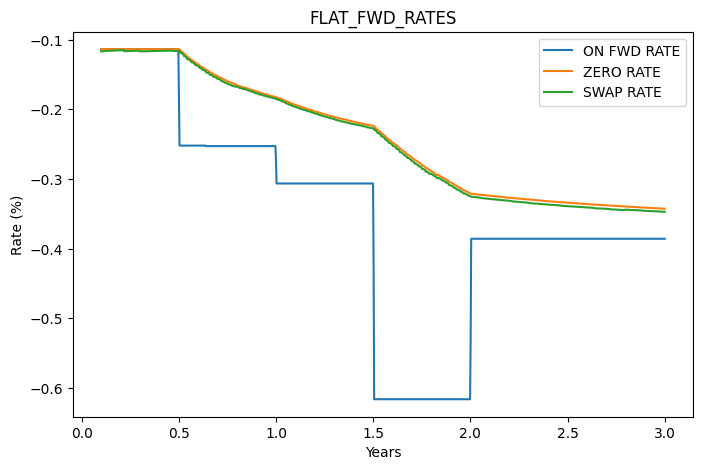

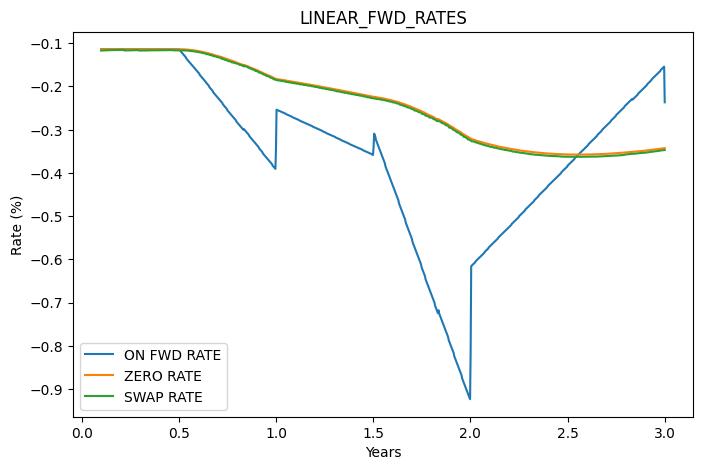

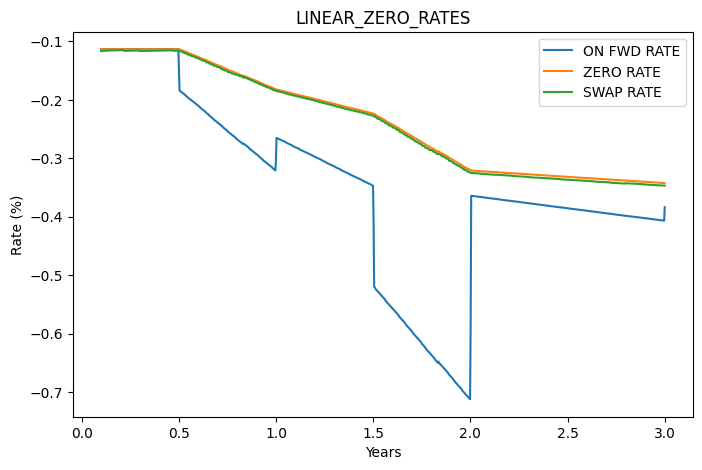

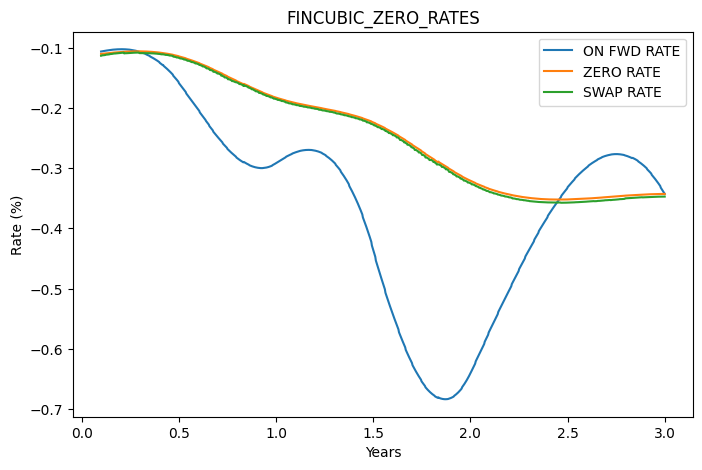

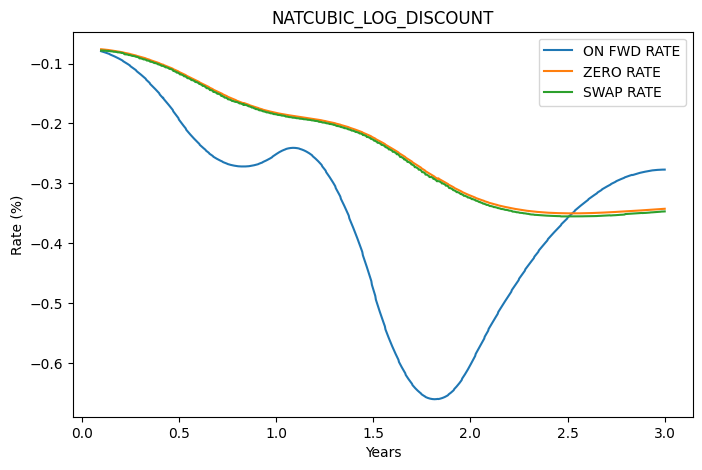

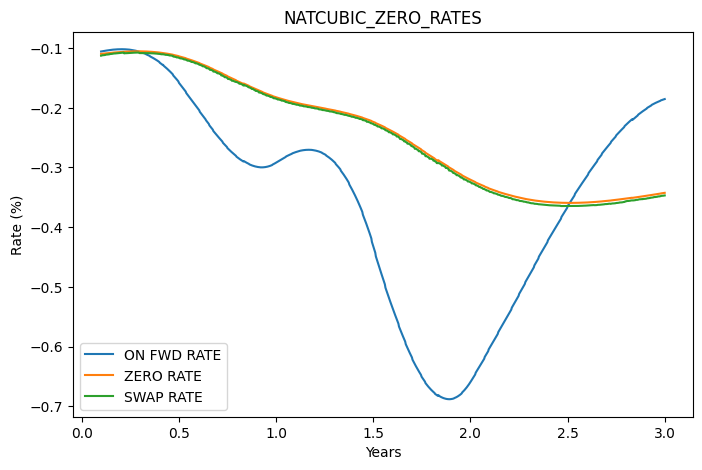

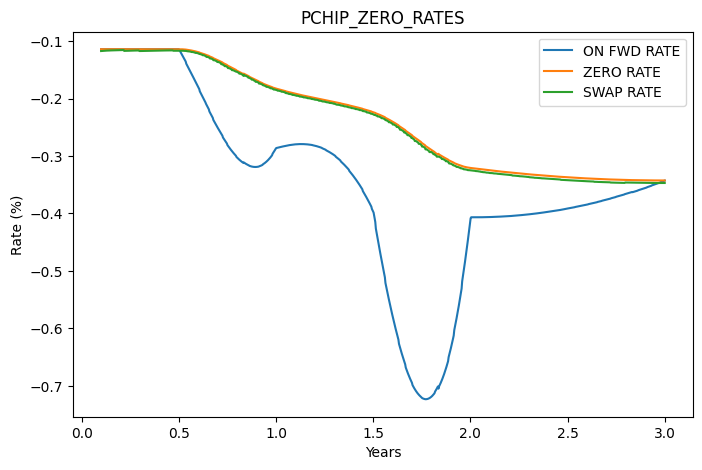

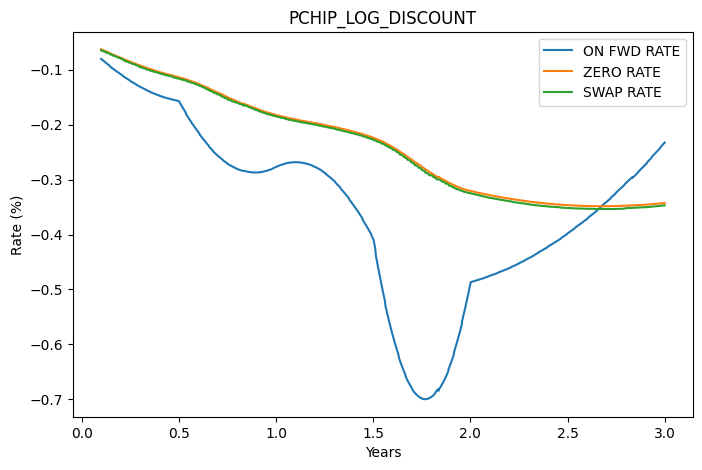

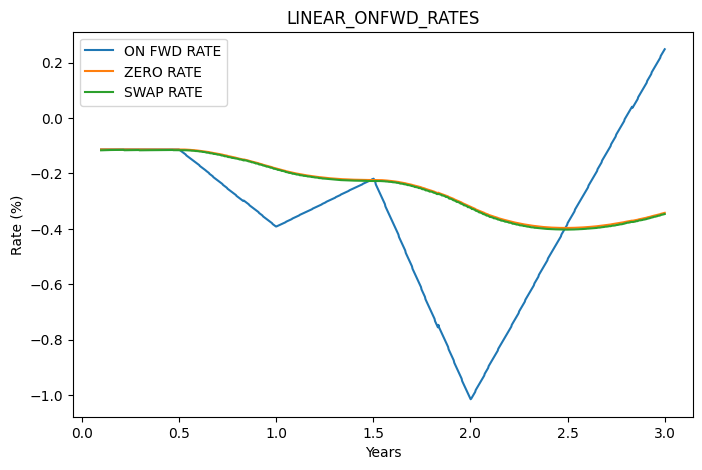

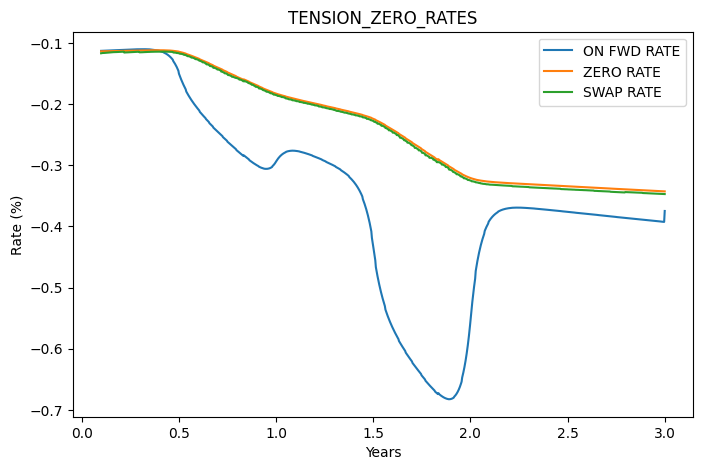

In [11]:
years = np.linspace(0.1, 3, 1000)
plotDates = settlement_date.add_years(years)

for interp_type in ibor_curves.keys():

    plt.figure(figsize=(8,5))
    ibor_curve = ibor_curves[interp_type]
    iborCurveFwdRate = ibor_curve.fwd_rate(plotDates, "1D")
    iborCurveZeroRate = ibor_curve.zero_rate(plotDates)
    iborCurveSwapRate = ibor_curve.swap_rate(settlement_date, plotDates)

    plt.plot(years, iborCurveFwdRate*100.0, label="ON FWD RATE")
    plt.plot(years, iborCurveZeroRate*100.0, label="ZERO RATE")
    plt.plot(years, iborCurveSwapRate*100.0, label="SWAP RATE")

    plt.title(interp_type.name)
    plt.xlabel("Years")
    plt.ylabel("Rate (%)")
    plt.legend()

Copyright (c) Dominic O'Kane 2020